In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/DataIntelligenceApplications/')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from utils.context_generator import ContextGenerator 
from data_generators.standard_generator import StandardDataGenerator
from environments.complete_environment import CompleteEnvironment
from learners.joint_contextual_learner import JointContextualLearner

In [3]:
src = 'src/basicCG.json'

In [4]:
#NEW!
dg = StandardDataGenerator(src)
print('src:\t',dg.get_source())
print('\nbid\tglobal\t\tr_aggr\t\t\tdelta')
aggr_arr = []
disaggr_arr = []
for j, bid in enumerate(dg.get_bids()):
    maxs=[]
    f_cost = dg.get_costs_per_click(mode='aggregate', bid=j)[j]
    clicks = dg.get_daily_clicks(mode='aggregate')[j]
    conv = dg.get_conversion_rates()
    fp = dg.get_future_purchases()
    for i in range(len(dg.get_classes())):
        maxs.append(np.max((conv[i] *(1 + fp[i]) * dg.get_margins() - dg.get_costs_per_click()[i,j]) * dg.get_daily_clicks()[i, j]))
    
    temp = (dg.get_margins() * np.average(conv * (1 + fp), axis=0, weights=dg.get_class_distributions(bid=j)) - 
        f_cost) * clicks
    
    #disaggr_arr.append(sum(maxs))
    aggr_arr.append(np.max(temp))
    disaggr = np.around(sum(maxs), decimals=4)
    disaggr_arr.append(disaggr)
    aggr = np.around(np.max(temp), decimals=4)
    delta = np.around(disaggr-aggr, decimals=4)
    print(f'{j}\t{disaggr}\t{aggr}\t-->\t{delta}')
opt_aggr = max(aggr_arr)
opt_bid = np.argmax(aggr_arr)
opt_disaggr = max(disaggr_arr)
opt_dis_bid = np.argmax(disaggr_arr)
print(f'\n{opt_disaggr} - {opt_dis_bid}')

src:	 src/basicCG.json

bid	global		r_aggr			delta
0	1255.2518	1181.2844	-->	73.9674
1	1290.195	1211.345	-->	78.85
2	1309.2055	1226.333	-->	82.8725
3	1316.4878	1228.2539	-->	88.2339
4	1300.7043	1209.0754	-->	91.6289
5	1257.1021	1162.1222	-->	94.9799
6	1203.32	1106.9154	-->	96.4046
7	1165.3041	1068.4519	-->	96.8522
8	1068.3859	971.023	-->	97.3629
9	971.6166	873.8864	-->	97.7302

1316.4878 - 3


In [5]:
dg = StandardDataGenerator(filename=src)

In [6]:
T = 365
n_experiments = 3
learners_to_test = [JointContextualLearner]
cg_start_from = 60
cg_confidence = 0.1
cg_frequency = 15

features = dg.get_features() 

rewards_per_experiment = {}
context_split_per_experiment = {}
days_of_split = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_per_experiment[learner.LEARNER_NAME] = []
    days_of_split[learner.LEARNER_NAME] = []

In [7]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'\n\nrunning experiment {e + 1}/{n_experiments}...')
    test_instances = []
    
    for learner in learners_to_test:
        context_learner = learner(margin_values=dg.get_margins(),
                                  bid_values=dg.get_bids(),
                                  features=dg.get_features())
        test_instances.append(
            (context_learner,
             CompleteEnvironment(src=src),
             ContextGenerator(features=features,
                              contextual_learner=context_learner,
                              update_frequency=cg_frequency,
                              start_from=cg_start_from,
                              confidence=cg_confidence,
                              verbose=1))
        )
    for t in range(T):
        for context_learner, env, context_generator in test_instances:
            #print(f'##### DAY {t} ######')
            context_learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            past_features = env.get_collected_user_features_at_day(t - 30, keep=False, filter_purchases=True)
            month_purchases = env.get_next_purchases_at_day(t, keep=True, filter_purchases=True)
            if month_purchases is not None:
                context_learner.update_next_purchases(past_arms, month_purchases, past_features)

            pulled_bid, pulled_prices = context_learner.pull_arms()
            print(f'[DAY {t}] SELECTED BID: {pulled_bid}, SELECTED PRICES: {pulled_prices}')

            daily_rewards, sampled_n_clicks, sampled_cpc = env.day_round(pulled_prices, pulled_bid, fixed_adv=False)
            context_learner.get_adv_params(sampled_n_clicks, sampled_cpc)

            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)
            
            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, 
                                                 daily_rewards, 
                                                 daily_users_features,
                                                 next_purchases=month_purchases, 
                                                 past_pulled_arms=past_arms,
                                                 past_features=past_features)
    for context_learner, _, _ in test_instances:
        context_learner.next_day()
        rewards_per_experiment[context_learner.LEARNER_NAME].append(context_learner.get_collected_reward())
        context_split_per_experiment[context_learner.LEARNER_NAME].append(context_learner.get_splits_count())
        days_of_split[context_learner.LEARNER_NAME].append(context_generator.metadata['SPLIT_DAYS'])
    
    # end -> save rhe results.



running experiment 1/3...
[DAY 0] SELECTED BID: 0, SELECTED PRICES: [({}, 8)]
[DAY 1] SELECTED BID: 1, SELECTED PRICES: [({}, 2)]
[DAY 2] SELECTED BID: 2, SELECTED PRICES: [({}, 7)]
[DAY 3] SELECTED BID: 3, SELECTED PRICES: [({}, 9)]
[DAY 4] SELECTED BID: 4, SELECTED PRICES: [({}, 3)]
[DAY 5] SELECTED BID: 5, SELECTED PRICES: [({}, 6)]
[DAY 6] SELECTED BID: 6, SELECTED PRICES: [({}, 0)]
[DAY 7] SELECTED BID: 7, SELECTED PRICES: [({}, 5)]
[DAY 8] SELECTED BID: 8, SELECTED PRICES: [({}, 4)]
[DAY 9] SELECTED BID: 9, SELECTED PRICES: [({}, 2)]
[DAY 10] SELECTED BID: 1, SELECTED PRICES: [({}, 8)]
[DAY 11] SELECTED BID: 0, SELECTED PRICES: [({}, 1)]
[DAY 12] SELECTED BID: 0, SELECTED PRICES: [({}, 7)]
[DAY 13] SELECTED BID: 1, SELECTED PRICES: [({}, 8)]
[DAY 14] SELECTED BID: 0, SELECTED PRICES: [({}, 1)]
[DAY 15] SELECTED BID: 1, SELECTED PRICES: [({}, 5)]
[DAY 16] SELECTED BID: 0, SELECTED PRICES: [({}, 8)]
[DAY 17] SELECTED BID: 1, SELECTED PRICES: [({}, 5)]
[DAY 18] SELECTED BID: 1, SE

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[DAY 208] SELECTED BID: 4, SELECTED PRICES: [({'feature-2': False, 'feature-1': False}, 0), ({'feature-2': False, 'feature-1': True}, 0), ({'feature-2': True}, 2)]
[DAY 209] SELECTED BID: 4, SELECTED PRICES: [({'feature-2': False, 'feature-1': False}, 0), ({'feature-2': False, 'feature-1': True}, 0), ({'feature-2': True}, 2)]
[DAY 210] SELECTED BID: 4, SELECTED PRICES: [({'feature-2': False, 'feature-1': False}, 0), ({'feature-2': False, 'feature-1': True}, 2), ({'feature-2': True}, 2)]

-------------------- RUNNING CONTEXT GENERATOR@t=210 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.868642668769219]
	Value before the split: 5.925015579611644

[DAY 211] SELECTED BID: 4, SELECTED PRICES: [({'feature-2': False, 'feature-1': False}, 0), ({'feature-2': False, 'feature-1': True}, 0), ({'feature-2': True}, 1)]
[DAY 212] SELECTED 

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)



-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']

Analysis of the feature `feature-1`...
	Values after the split: [5.8890698333162215]
	Value before the split: 5.951772857612822

[DAY 241] SELECTED BID: 4, SELECTED PRICES: [({'feature-2': False, 'feature-1': False}, 0), ({'feature-2': False, 'feature-1': True}, 8), ({'feature-2': True}, 3)]
[DAY 242] SELECTED BID: 4, SELECTED PRICES: [({'feature-2': False, 'feature-1': False}, 0), ({'feature-2': False, 'feature-1': True}, 0), ({'feature-2': True}, 2)]
[DAY 243] SELECTED BID: 4, SELECTED PRICES: [({'feature-2': False, 'feature-1': False}, 0), ({'feature-2': False, 'feature-1': True}, 0), ({'feature-2': True}, 2)]
[DAY 244] SELECTED BID: 4, SELECTED PRICES: [({'feature-2': False, 'feature-1': False}, 0), ({'feature-2': False, 'feature-1': True}, 0), ({'feature-2': True}, 2)]
[DAY 245] SELECTED

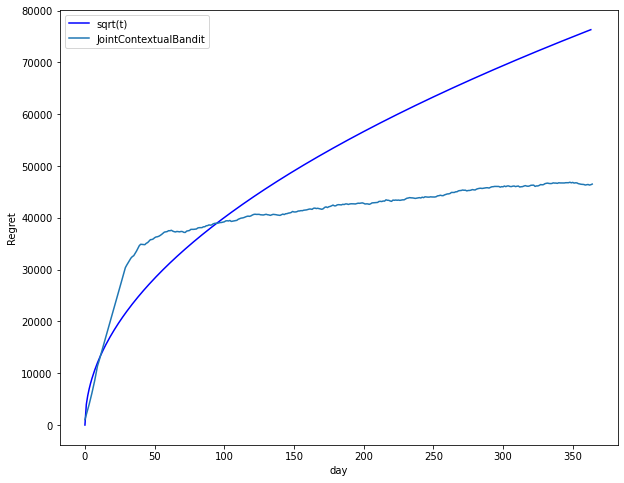

In [8]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")

plt.plot(4000*np.sqrt(np.linspace(0,364,364)), 'b')
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(opt_disaggr - val, axis=0)))

plt.legend(['sqrt(t)'] + list(rewards_per_experiment.keys()))
plt.show()

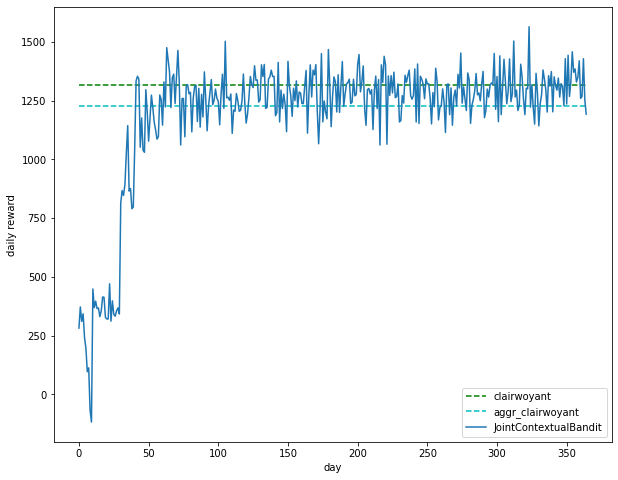

In [9]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([opt_disaggr]*T, '--g', label='clairwoyant')
plt.plot([opt_aggr]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

plt.legend(loc='best')
plt.show()

In [10]:
l = [3, 4, 5]
for i, el in enumerate(l):
  print(i, el)

0 3
1 4
2 5
